# Importowanie niezbędnych bibliotek

In [1]:
# Importy standardowej biblioteki
import glob
import os
import torch
import torch.serialization
from datetime import datetime

# Importy bibliotek zewnętrznych
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report)

# Importy własnych modułów
from config import BATCH_SIZE, DEVICE,TEST_SPLIT, CLASS_NAMES,FEATURE_RESULTS_DIR, PROCESSED_FEATURES_DIR, ENSEMBLE_OUTPUT_DIR, OPTUNA_TRIALS, OPTUNA_TIMEOUT, CV_FOLDS, SEED

from helpers.resnet_model_definition import AudioResNet

from helpers.ensemble_trainer import EnsembleModelTrainer
from export_scripts.ensemble_onnx_wrapper import quantize_onnx_model


# Ustawienie domyślnego urządzenia
print(f"Using device: {DEVICE}")

Using device: cpu


## Automatyczna konfiguracja modelu ensemble

### Funkcja `find_latest_model`
**Opis:**  
Ta funkcja wyszukuje najnowszy plik modelu dla określonego typu cechy audio w katalogu z wynikami. Wykorzystuje wzorzec nazwy pliku, aby znaleźć wszystkie modele dla danego typu cechy, a następnie sortuje je według daty w nazwie pliku, zwracając najnowszy.

**Uzasadnienie:**  
Wybór najnowszego modelu jest kluczowy w procesie ensemble, ponieważ zapewnia, że używane są najbardziej aktualne wyniki treningu, co może wpływać na lepszą dokładność predykcji.

### Funkcja `find_feature_file`
**Opis:**  
Funkcja ta wyszukuje plik z cechami audio dla określonego typu reprezentacji w katalogu z przetworzonymi cechami. Jeśli znajdzie więcej niż jeden plik, wybiera najnowszy na podstawie daty modyfikacji.

**Uzasadnienie:**  
Wybór odpowiedniego pliku z cechami jest niezbędny do zapewnienia, że dane wejściowe do modelu są aktualne i zgodne z typem cechy, co pozwala na spójność między danymi a modelem podczas predykcji lub treningu.

### Funkcja `auto_configure_ensemble`
**Opis:**  
Funkcja automatycznie konfiguruje model ensemble, wyszukując dostępne typy cech w katalogu wyników, znajdując odpowiednie modele i pliki cech dla każdego typu, a następnie tworząc konfigurację z modelami, plikami cech, wagami początkowymi i parametrami eksperymentu.
W tym fragmencie kodu definiowana jest struktura config jako słownik, który zawiera kluczowe ustawienia modelu ensemble. Obejmuje ścieżki do modeli (model_paths) i plików cech (feature_files), klasę modelu (AudioResNet z pliku resnet_model_definition.py), początkowe wagi dla ensemble (initial_weights), katalog wyjściowy (output_dir z config.py), nazwę eksperymentu, podział danych na testowe (test_split), rozmiar partii (batch_size), parametry optymalizacji Optuna (optimization), nazwy klas emocji (class_names) oraz ziarno losowości (random_seed), z których większość pochodzi z pliku config.py.

**Uzasadnienie:**  
Automatyczna konfiguracja pozwala na szybkie zestawienie modelu ensemble bez konieczności ręcznego określania ścieżek do modeli i plików cech, co minimalizuje ryzyko błędów ludzkich i przyspiesza proces przygotowania do treningu lub testowania. Funkcja sprawdza również, czy wszystkie wymagane pliki istnieją, co zapobiega problemom podczas dalszej pracy. Konfiguracja config centralizuje wszystkie parametry potrzebne do treningu i testowania modelu ensemble, zapewniając spójność między ustawieniami projektu (config.py), architekturą modelu (resnet_model_definition.py) a danymi, co ułatwia automatyzację i powtarzalność eksperymentów.


In [2]:
def find_latest_model(feature_type):
    """Zwraca najnowszy model dla danej reprezentacji audio."""
    search_pattern = f"{FEATURE_RESULTS_DIR}/{feature_type}/best_model_{feature_type}_*.pt"
    model_files = glob.glob(search_pattern)
    
    if not model_files:
        return None
    
    # Sortowanie plików według daty w nazwie (najnowszy na końcu)
    model_files.sort(key=lambda x: os.path.basename(x).split('_')[-1].split('.')[0])
    return model_files[-1]

def find_feature_file(feature_type):
    """Zwraca plik z cechami dla danej reprezentacji audio."""
    search_pattern = f"{PROCESSED_FEATURES_DIR}/{feature_type}_*.pkl"
    feature_files = glob.glob(search_pattern)
    
    if not feature_files:
        return None
    
    # W przypadku wielu plików, wybór najnowszego
    if len(feature_files) > 1:
        feature_files.sort(key=os.path.getmtime, reverse=True)
    
    return feature_files[0]

def auto_configure_ensemble(feature_types=None):
    """
    Konfiguracja modelu ensemble w sposób automatyczny.
    """
    # Wykorzystanie zmiennych z config.py
    if feature_types is None:
        try:
            feature_types = [d for d in os.listdir(FEATURE_RESULTS_DIR) 
                             if os.path.isdir(os.path.join(FEATURE_RESULTS_DIR, d))]
        except FileNotFoundError:
             raise FileNotFoundError(f"Nie znaleziono katalogu '{FEATURE_RESULTS_DIR}'.")
    
    print(f"Typy cech wybrane do modelu ensemble: {', '.join(feature_types)}")

    model_paths = {}
    feature_files = {}
    initial_weights = {}
    missing_feature_files = []
    
    for feature_type in feature_types:
        # Weryfikacja pliku cech
        feature_file = find_feature_file(feature_type)
        if not feature_file:
            missing_feature_files.append(feature_type)
            print(f"Ostrzeżenie: Brak pliku cech dla {feature_type}")
            continue # Kontynuacja do następnego typu, bez szukania modelu, gdy brak cech
        
        feature_files[feature_type] = feature_file
        
        # Wyszukiwanie modelu
        model_path = find_latest_model(feature_type)
        if model_path:
            model_paths[feature_type] = model_path
            initial_weights[feature_type] = 1.0 # Waga do normalizacji w późniejszym etapie
        else:
            print(f"Ostrzeżenie: Brak modelu dla {feature_type}, mimo istnienia pliku cech.")
            # Decyzja o kontynuacji bez tego modelu lub zgłoszenie błędu.
            # Na razie pominięcie tego typu cechy w modelu.
            del feature_files[feature_type] # Usunięcie wpisu o pliku cech, gdy brak modelu
            
    # W przypadku brakujących plików cech, zgłoszenie błędu
    if missing_feature_files:
        error_message = (
            f"Błąd: Brak plików cech dla: {', '.join(missing_feature_files)}. "
            f"Zaleca się uruchomienie funkcji `process_dataset` w pliku `ResNet_porównanie.ipynb`, "
            f"aby wygenerować brakujące pliki w folderze `processed_features`."
        )
        raise FileNotFoundError(error_message)
        
    # Weryfikacja, czy znaleziono jakiekolwiek działające pary model-cechy
    if not model_paths:
        raise ValueError("Brak działających modeli i odpowiadających im plików cech! "
                         "Zaleca się sprawdzenie folderów 'feature_comparison_results' i 'processed_features'.")

    # Normalizacja wag, aby sumowały się do 1
    num_features = len(model_paths)
    initial_weights = {k: 1.0 / num_features for k in model_paths.keys()}
    
    # Tworzenie konfiguracji
    config = {
        "model_paths": model_paths,
        "model_class": AudioResNet,
        "feature_files": feature_files,
        "initial_weights": initial_weights,
        "output_dir": ENSEMBLE_OUTPUT_DIR,
        "experiment_name": f"ensemble_model_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
        "test_split": TEST_SPLIT,
        "batch_size": BATCH_SIZE,
        "optimization": {
            "n_trials": OPTUNA_TRIALS,
            "timeout": OPTUNA_TIMEOUT,
            "n_folds": CV_FOLDS
        },
        "class_names": CLASS_NAMES,
        "random_seed": SEED
    }
    
    
    print(f"\nZnaleziono {len(model_paths)} działających par model-cechy:")
    for feat in model_paths.keys():
        print(f"  - {feat}")
    
    return config

## Konfiguracja modelu ensemble z wybranymi cechami

In [3]:
# Automatyczne wykrywanie dostępnych modeli
# CONFIG = auto_configure_ensemble()

# Selekcja konkretnych reprezentacji
selected_features = ["melspectrogram", "mfcc", "chroma"]
CONFIG = auto_configure_ensemble(feature_types=selected_features)

# Modyfikacja wygenerowanej konfiguracji w celu dostosowania liczby prób optymalizacji
# CONFIG["optimization"]["n_trials"] = 100  # Ustalenie liczby prób optymalizacji

Typy cech wybrane do modelu ensemble: melspectrogram, mfcc, chroma

Znaleziono 3 działających par model-cechy:
  - melspectrogram
  - mfcc
  - chroma


## Opis funkcji `auto_configure_ensemble`:
Funkcja `auto_configure_ensemble` w pliku `ResNet_ensemble.ipynb` automatycznie przygotowuje model ensemble, przeszukując katalogi zdefiniowane w `config.py` w poszukiwaniu najnowszych modeli i plików cech dla różnych reprezentacji audio. Tworzy konfigurację zawierającą ścieżki do modeli, pliki cech, klasę modelu `AudioResNet` (z resnet_model_definition.py), znormalizowane wagi początkowe oraz parametry eksperymentu i optymalizacji.
## Uzasadnienie architektury i featurów:
Architektura ensemble łączy predykcje różnych modeli bazowych, analizujących odmienne cechy audio, co pozwala lepiej uchwycić emocje w dźwięku. W szczególności model ensemble osiągnął najlepsze wyniki po kilku próbach z różnymi konfiguracjami, wykorzystując trzy reprezentacje: chroma (harmonia i tony), melspectrogram (częstotliwości dostosowane do ludzkiego słuchu) oraz mfcc (cechy cepstralne istotne w analizie mowy). Automatyzacja konfiguracji oszczędza czas i minimalizuje błędy, umożliwiając skupienie się na analizie wyników.
## Analiza pliku `ensemble_trainer.py`:
Plik `ensemble_trainer.py` definiuje klasę `EnsembleModelTrainer`, która zarządza trenowaniem i oceną modelu ensemble. Odpowiada za ładowanie modeli   `AudioResNet` i danych cech, optymalizację wag za pomocą Optuna (z parametrami z `config.py`), ocenę modelu na zbiorze testowym, generowanie macierzy pomyłek oraz analizę błędów. Wykorzystuje MLflow do logowania eksperymentów, a walidacja krzyżowa i podział danych (zgodnie z `TEST_SPLIT`) zapewniają rzetelność wyników.

Zastosowanie ensemble z wybranymi cechami audio (chroma, melspectrogram, mfcc) pozwala uchwycić złożoność emocji w dźwiękach, a modularna struktura `EnsembleModelTrainer` ułatwia zarządzanie eksperymentami. Automatyzacja optymalizacji wag i logowanie wyników wspierają efektywność i powtarzalność, co jest kluczowe w badaniach nad rozpoznawaniem emocji.

In [4]:
# Inicjalizacja konfiguracji
if 'CONFIG' not in locals():
    try:
        print("Rozpoczynanie automatycznego generowania konfiguracji...")
        CONFIG = auto_configure_ensemble() 
    except Exception as e:
        raise NameError(f"Zmienna CONFIG nie jest zdefiniowana i nie udało się jej automatycznie wygenerować: {e}. Należy najpierw uruchomić komórkę konfiguracyjną lub upewnić się, że pliki modeli/cech są dostępne.")

# Tworzenie głównego katalogu wyjściowego dla bieżącego uruchomienia
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# Wykorzystanie podstawowego output_dir z konfiguracji
base_output_dir = CONFIG.get("output_dir", "ensemble_outputs") 
output_dir = os.path.join(base_output_dir, f"ensemble_run_{timestamp}")
os.makedirs(output_dir, exist_ok=True)
print(f"Główny katalog wyjściowy utworzony: {output_dir}")     

# Inicjalizacja trenera z odpowiednim output_dir
trainer = EnsembleModelTrainer(
    model_paths=CONFIG["model_paths"],
    feature_files=CONFIG["feature_files"],
    model_class=CONFIG["model_class"],  # Nowy parametr
    output_dir=output_dir
)


print("Inicjalizacja zakończona. Można przystąpić do optymalizacji lub treningu.")

Główny katalog wyjściowy utworzony: c:\Users\kubas\Desktop\Projekt dyplomowy\Audio-Emotion-Recognition\src\ensemble_outputs\ensemble_run_20250514_181347
Próba załadowania modelu dla cechy 'melspectrogram' z c:\Users\kubas\Desktop\Projekt dyplomowy\Audio-Emotion-Recognition\src\feature_comparison_results/melspectrogram\best_model_melspectrogram_20250509_094328.pt
Model załadowany pomyślnie z c:\Users\kubas\Desktop\Projekt dyplomowy\Audio-Emotion-Recognition\src\feature_comparison_results/melspectrogram\best_model_melspectrogram_20250509_094328.pt
Pomyślnie załadowano model dla cechy 'melspectrogram'
Próba załadowania modelu dla cechy 'mfcc' z c:\Users\kubas\Desktop\Projekt dyplomowy\Audio-Emotion-Recognition\src\feature_comparison_results/mfcc\best_model_mfcc_20250509_100943.pt
Model załadowany pomyślnie z c:\Users\kubas\Desktop\Projekt dyplomowy\Audio-Emotion-Recognition\src\feature_comparison_results/mfcc\best_model_mfcc_20250509_100943.pt
Pomyślnie załadowano model dla cechy 'mfcc'
P

## Optymalizacja wag

Poniżej pobierane są parametry optymalizacji z wcześniej zdefiniowanej konfiguracji `CONFIG`, takie jak liczba prób (`n_trials`), limit czasu (`timeout`), liczba foldów walidacji krzyżowej (`n_folds`) oraz proporcja danych testowych (`test_size`). Następnie wywoływana jest metoda `optimize_weights` obiektu `trainer`, która wykorzystuje bibliotekę **Optuna** do znalezienia najlepszych wag dla każdego modelu bazowego w ensemble. Na koniec wyświetlane są informacje o zakończeniu optymalizacji oraz uzyskane najlepsze wagi (`best_weights`).

Optymalizacja wag jest kluczowym krokiem w budowie modelu ensemble, ponieważ pozwala określić, jak bardzo każdy model bazowy (dla różnych cech audio) wpływa na ostateczną predykcję. Użycie Optuna automatyzuje ten proces, testując różne kombinacje wag w oparciu o walidację krzyżową, co prowadzi do poprawy dokładności modelu. Logowanie parametrów i wyników zapewnia przejrzystość i możliwość analizy procesu optymalizacji.

In [5]:
# # Komórka odpowiedzialna za optymalizację wag modelu, w której definiowane są parametry optymalizacji
# n_trials = CONFIG["optimization"]["n_trials"]
# timeout = CONFIG["optimization"]["timeout"]
# n_folds = CONFIG["optimization"]["n_folds"]
# test_size = CONFIG["test_split"]

# print(f"Rozpoczynanie optymalizacji z {n_trials} próbami...")
# best_weights = trainer.optimize_weights(
#     n_trials=n_trials,
#     timeout=timeout,
#     n_folds=n_folds,
#     test_size=test_size
# )

# print("Optymalizacja zakończona!")
# print(f"Najlepsze wagi: {best_weights}")

## Trening i ewaluacja modelu

Komórka poniżej umożliwia elastyczne testowanie modelu ensemble z różnymi zestawami wag – zarówno zoptymalizowanymi automatycznie, jak i ustawionymi ręcznie, co pozwala eksperymentować z wpływem poszczególnych reprezentacji audio na wynik. Wywołanie metody `train_and_evaluate` integruje proces treningu i oceny, korzystając z wcześniej przygotowanej konfiguracji.

In [6]:
# Komórka odpowiedzialna za trening i ewaluację modelu, która powinna być uruchomiona po zakończeniu optymalizacji lub przy użyciu zdefiniowanych wag.
# Możliwość wykorzystania wag uzyskanych w poprzednim kroku lub zdefiniowanie własnych wag.
# Przykład z własnymi wagami:


custom_weights = {
"chroma": 0.13857384163072003,
"melspectrogram": 0.31651310994496806,
"mfcc": 0.544913048424312
}

# Wybór wag do użycia, które mogą być najlepszymi wagami lub zdefiniowanymi przez użytkownika
weights_to_use = custom_weights  # lub custom_weights, jeśli zdefiniowano

print(f"Trenowanie i ewaluacja modelu z wagami: {weights_to_use}")
ensemble_model, test_results = trainer.train_and_evaluate(
    weights=weights_to_use,
    test_size=CONFIG["test_split"],
    batch_size=CONFIG["batch_size"]
)

print("Trenowanie i ewaluacja zakończona!")
print(f"Dokładność testowa: {test_results.get('accuracy', 0.0):.4f}")
print(f"Wynik F1 testu: {test_results.get('f1', 0.0):.4f}")

Trenowanie i ewaluacja modelu z wagami: {'chroma': 0.13857384163072003, 'melspectrogram': 0.31651310994496806, 'mfcc': 0.544913048424312}
Trenowanie i ewaluacja zakończona!
Dokładność testowa: 0.9487
Wynik F1 testu: 0.9488


## Szczegółowe wyniki modelu

Raport klasyfikacji:
              precision    recall  f1-score   support

       anger       0.97      0.96      0.96       150
        fear       0.97      0.98      0.98       147
   happiness       0.92      0.92      0.92       150
     neutral       0.95      0.98      0.96       162
     sadness       0.99      0.95      0.97       154
   surprised       0.89      0.90      0.89       134

    accuracy                           0.95       897
   macro avg       0.95      0.95      0.95       897
weighted avg       0.95      0.95      0.95       897



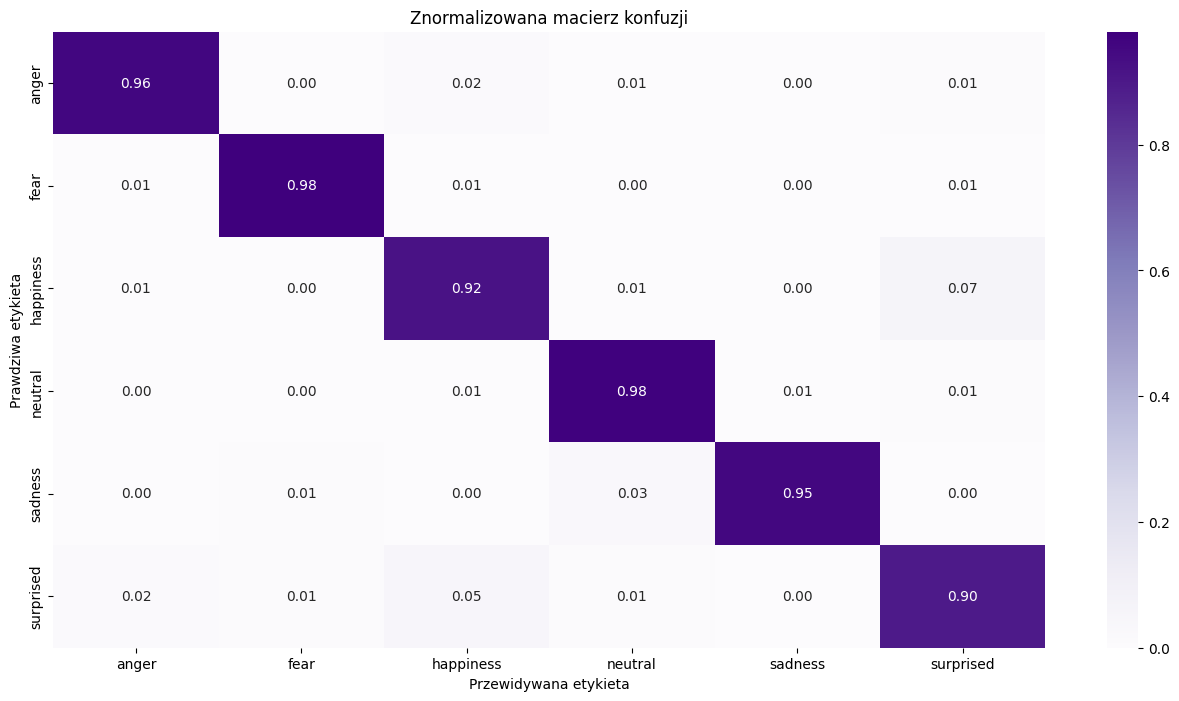

In [7]:
# Komórka odpowiedzialna za wyświetlanie szczegółowych wyników
# Wymagana po zakończeniu procesu treningu i ewaluacji
if 'test_results' in locals():
    # Generowanie szczegółowego raportu klasyfikacji
    print("Raport klasyfikacji:")
    class_names = CONFIG["class_names"]
    print(classification_report(test_results['true'], test_results['preds'], target_names=class_names))
    
    # Tworzenie i wyświetlanie znormalizowanej macierzy konfuzji
    plt.figure(figsize=(16, 8))
    cm_normalized = test_results['cm'].astype('float') / test_results['cm'].sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Purples',
               xticklabels=class_names, yticklabels=class_names)
    plt.title('Znormalizowana macierz konfuzji')
    plt.ylabel('Prawdziwa etykieta')
    plt.xlabel('Przewidywana etykieta')
    plt.show()

### Inspekcja modeli PyTorch

In [8]:
def add_safe_globals_for_pytorch():
    """
    Dodaje niezbędne klasy/funkcje do bezpiecznej listy PyTorch
    """
    try:
        # Lista potencjalnie wymaganych klas/funkcji 
        safe_globals = [
            torch.torch_version.TorchVersion,
            np.core.multiarray._reconstruct,
            np.ndarray,
            np.dtype
        ]
        
        # Dodanie wszystkich klas/funkcji do bezpiecznej listy
        for safe_global in safe_globals:
            try:
                torch.serialization.add_safe_globals([safe_global])
            except Exception as e:
                print(f"Nie można dodać do bezpiecznych globali: {e}")
                
    except Exception as e:
        print(f"Ostrzeżenie: Nie można dodać niektórych klas do bezpiecznych globali: {e}")

def safe_inspect_model(path):
    """
    Bezpieczna funkcja do inspekcji zawartości modelu PyTorch
    
    Args:
        path (str): Ścieżka do pliku .pt z zapisanym modelem
    """
    print(f"Inspekcja pliku modelu: {path}")
    print(f"Wersja PyTorch: {torch.__version__}")
    
    # Dodanie bezpiecznych globali
    add_safe_globals_for_pytorch()
    
    # Próba ładowania - najpierw weights_only=False (działa, ale mniej bezpieczne)
    try:
        print("\nPróba ładowania z weights_only=False...")
        state = torch.load(path, map_location=torch.device('cpu'), weights_only=False)
        print("Sukces z weights_only=False!")
        
        print("\nKlucze dostępne w pliku stanu modelu:")
        for key in state.keys():
            print(f"- {key}")
            
        print("\nSzczegółowe informacje:")
        for key, value in state.items():
            if isinstance(value, (str, int, float, bool)):
                print(f"{key}: {value}")
            elif isinstance(value, (list, tuple)) and len(value) < 10:
                print(f"{key}: {value}")
            elif isinstance(value, dict) and len(value) < 10:
                print(f"{key}: {value}")
            elif isinstance(value, dict):
                print(f"{key}: {type(value)} z {len(value)} elementami")
                print("  Przykłady:")
                for i, (k, v) in enumerate(value.items()):
                    if i >= 3: break
                    print(f"  - {k}: {type(v)}")
            else:
                print(f"{key}: {type(value)}")
        
        return state
                
    except Exception as e:
        print(f"Błąd podczas wczytywania pliku: {str(e)}\n")
        
        # Jeśli jednak się nie udało, sprawdź metadane JSON
        try:
            metadata_path = path.replace('.pt', '_metadata.json')
            print(f"Próba wczytania metadanych z: {metadata_path}")
            import json
            with open(metadata_path, 'r') as f:
                metadata = json.load(f)
            
            print("\nMetadane modelu:")
            for key, value in metadata.items():
                print(f"- {key}: {value}")
            
            return metadata
        except Exception as e_meta:
            print(f"Nie udało się wczytać metadanych: {str(e_meta)}")
            
        return None

model_path = "ensemble_outputs\ensemble_run_20250510_204105\models\ensemble_model.pt"
model_state = safe_inspect_model(model_path) 

Inspekcja pliku modelu: ensemble_outputs\ensemble_run_20250510_204105\models\ensemble_model.pt
Wersja PyTorch: 2.7.0+cpu

Próba ładowania z weights_only=False...
Błąd podczas wczytywania pliku: [Errno 2] No such file or directory: 'ensemble_outputs\\ensemble_run_20250510_204105\\models\\ensemble_model.pt'

Próba wczytania metadanych z: ensemble_outputs\ensemble_run_20250510_204105\models\ensemble_model_metadata.json
Nie udało się wczytać metadanych: [Errno 2] No such file or directory: 'ensemble_outputs\\ensemble_run_20250510_204105\\models\\ensemble_model_metadata.json'


### Eksport modelu ensemble do formatu ONNX

In [ ]:
# Import funkcji eksportu
import os
import torch
import inspect
from datetime import datetime
from export_scripts.ensemble_onnx_wrapper import quantize_onnx_model
from export_scripts.export_onnx_notebook_helper import export_model_to_onnx

# Sprawdź dostępność GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Używane urządzenie: {device}")
print(f"Wersja PyTorch: {torch.__version__}")

# Sprawdź czy model i konfiguracja są dostępne
if 'ensemble_model' in locals() and 'CONFIG' in locals():
    print("\nModel ensemble i konfiguracja znalezione!")
    
    # Utwórz katalog wyjściowy z timestampem
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    output_dir = f"exported_models/onnx_{timestamp}"
    os.makedirs(output_dir, exist_ok=True)
    print(f"Katalog wyjściowy: {output_dir}")
    
    # Konfiguracja kwantyzacji
    quantize_model = True         # Czy kwantyzować model po eksporcie
    quantization_type = "dynamic" # Typ kwantyzacji 
    quantization_dtype = "uint8"  # Typ danych kwantyzacji
    
    print("\nRozpoczynam eksport modelu...")
    
    # Eksport modelu do formatu ONNX
    try:
        export_result = export_model_to_onnx(
            ensemble_model=ensemble_model,
            output_dir=output_dir,
            class_names=CONFIG.get("class_names"),
            export_params={
                "quantize_model": quantize_model,
                "quantization_type": quantization_type,
                "quantization_dtype": quantization_dtype,
                "use_cuda": device.type == 'cuda'
            }
        )
    except TypeError as e:
        print(f"Błąd: {e}")
        try:
            sig = inspect.signature(export_model_to_onnx)
            print(f"Oczekiwane parametry: {list(sig.parameters.keys())}")
        except:
            print("Nie udało się uzyskać parametrów funkcji.")
        raise
    
    if export_result.get("success", False):
        print("\nEksport modelu ensemble do ONNX zakończony sukcesem!")
        print(f"Model ONNX zapisany w: {export_result['onnx_path']}")
        print(f"Zoptymalizowany model ONNX zapisany w: {export_result['optimized_onnx_path']}")
        
        # Rozmiar modelu
        original_size_mb = os.path.getsize(export_result['onnx_path']) / (1024*1024)
        optimized_size_mb = os.path.getsize(export_result['optimized_onnx_path']) / (1024*1024)
        print(f"Rozmiar oryginalnego modelu: {original_size_mb:.2f} MB")
        print(f"Rozmiar zoptymalizowanego modelu: {optimized_size_mb:.2f} MB")
        print(f"Redukcja rozmiaru po optymalizacji: {export_result.get('optimization_reduction', 0):.2f}%")
        
        # Sprawdź czy kwantyzacja została wykonana w funkcji eksportu
        if "quantized_onnx_path" in export_result and os.path.exists(export_result['quantized_onnx_path']):
            quantized_size_mb = os.path.getsize(export_result['quantized_onnx_path']) / (1024*1024)
            print(f"Skwantyzowany model ONNX zapisany w: {export_result['quantized_onnx_path']}")
            print(f"Rozmiar skwantyzowanego modelu: {quantized_size_mb:.2f} MB")
            print(f"Redukcja rozmiaru po kwantyzacji: {export_result.get('quantization_reduction', 0):.2f}%")
        else:
            print("Kwantyzacja nie została przeprowadzona w ramach procesu eksportu.")
        
        # Informacje o metadanych i weryfikacji
        print(f"Metadane modelu zapisane w: {export_result.get('metadata_path', 'N/A')}")
        
        # Wyświetl wyniki weryfikacji
        if "verification_result" in export_result:
            result = export_result["verification_result"]
            if result.get("success", False):
                print("\nWeryfikacja modelu zakończona powodzeniem")
                if "max_diff" in result:
                    print(f"Maksymalna różnica między PyTorch i ONNX: {result['max_diff']:.6f}")
                if "has_warning" in result and result["has_warning"]:
                    print(f"Ostrzeżenie: {result.get('warning', 'Wykryto różnice, ale mieszczą się w tolerancji')}")
            else:
                print(f"\nWeryfikacja modelu nie powiodła się: {result.get('error', 'Nieznany błąd')}")
    else:
        print("\nEksport modelu się nie powiódł")
        print(f"Błąd: {export_result.get('error', 'Nieznany błąd')}")
else:
    print("Błąd: Nie znaleziono zmiennych ensemble_model i/lub CONFIG.")


Używane urządzenie: cpu
Wersja PyTorch: 2.7.0+cpu

Model ensemble i konfiguracja znalezione!
Katalog wyjściowy: exported_models/onnx_20250514_181401

Rozpoczynam eksport modelu...
Katalog wyjściowy: exported_models/onnx_20250514_181401

Generowanie przykładowych danych wejściowych...
Wymiary wejść:
 - mel_input:   torch.Size([1, 1, 128, 130])
 - mfcc_input:  torch.Size([1, 1, 40, 130])
 - chroma_input: torch.Size([1, 1, 12, 130])

--- Eksport modelu do formatu ONNX ---
Rozpoczynam eksport modelu ensemble do formatu ONNX: exported_models/onnx_20250514_181401\ensemble_model.onnx
Test forward pass zakończony sukcesem. Kształt wyjścia: torch.Size([1, 6])
Wymiary wejść:
 - mel_input:   torch.Size([1, 1, 128, 130])
 - mfcc_input:  torch.Size([1, 1, 40, 130])
 - chroma_input: torch.Size([1, 1, 12, 130])


c:\Users\kubas\Desktop\Projekt dyplomowy\Audio-Emotion-Recognition\.venv\lib\site-packages\onnxscript\converter.py:816: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
c:\Users\kubas\Desktop\Projekt dyplomowy\Audio-Emotion-Recognition\.venv\lib\site-packages\onnxscript\converter.py:816: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
c:\Users\kubas\Desktop\Projekt dyplomowy\Audio-Emotion-Recognition\src\export_scripts\ensemble_onnx_wrapper.py:97: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(


[torch.onnx] Obtain model graph for `EnsembleONNXWrapper([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `EnsembleONNXWrapper([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


c:\Users\kubas\Desktop\Projekt dyplomowy\Audio-Emotion-Recognition\.venv\lib\site-packages\torch\export\_unlift.py:81: UserWarning: Attempted to insert a get_attr Node with no underlying reference in the owning GraphModule! Call GraphModule.add_submodule to add the necessary submodule, GraphModule.add_parameter to add the necessary Parameter, or nn.Module.register_buffer to add the necessary buffer
  getattr_node = gm.graph.get_attr(lifted_node)
c:\Users\kubas\Desktop\Projekt dyplomowy\Audio-Emotion-Recognition\.venv\lib\site-packages\torch\fx\graph.py:1772: UserWarning: Node ensemble_lifted_tensor_0 target ensemble.lifted_tensor_0 lifted_tensor_0 of ensemble does not reference an nn.Module, nn.Parameter, or buffer, which is what 'get_attr' Nodes typically target
  warnings.warn(


[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...


Conversion to opset < 18 is not supported.


[torch.onnx] Translate the graph into ONNX... ✅
Applied 3 of general pattern rewrite rules.
Eksport do ONNX zakończony pomyślnie!
Weryfikacja modelu ONNX...
✓ Model ONNX poprawny!
Rozmiar modelu: 0.49 MB
Liczba węzłów grafu: 226
Liczba inicjalizatorów: 366
Model wyeksportowany do: exported_models/onnx_20250514_181401\ensemble_model.onnx

--- Optymalizacja modelu ONNX ---
Rozpoczęcie optymalizacji modelu ONNX: exported_models/onnx_20250514_181401\ensemble_model.onnx
Utworzono kopię zapasową oryginalnego modelu: exported_models/onnx_20250514_181401\ensemble_model.onnx.backup
Rozmiar oryginalnego modelu: 0.49 MB
Używanie bezpiecznych optymalizacji...
Model po optymalizacji poprawny.
Ostrzeżenie: Zoptymalizowany model jest znacznie większy (128.08 MB) niż oryginalny (0.49 MB). Używanie oryginału.

--- Kwantyzacja modelu ONNX ---
Rozpoczęcie kwantyzacji modelu ONNX: exported_models/onnx_20250514_181401\ensemble_model_optimized.onnx
Model ONNX poprawny przed kwantyzacją.
Shape inference prze

Podstawowa kwantyzacja nie powiodła się: [ShapeInferenceError] Inferred shape and existing shape differ in dimension 0: (512) vs (6)
Próba kwantyzacji z pominięciem problematycznych operatorów...
Pominięcie operatorów: ['Reshape', 'Transpose', 'Concat', 'Slice', 'Squeeze', 'Unsqueeze']
Również nie powiodła się kwantyzacja z pominięciem operatorów: quantize_dynamic() got an unexpected keyword argument 'op_types_to_exclude'
Próba ostatecznej, minimalnej kwantyzacji...
Kwantyzacja tylko operatorów: ['Conv', 'MatMul']


Wszystkie próby kwantyzacji nieudane: [ShapeInferenceError] Inferred shape and existing shape differ in dimension 0: (512) vs (6)
Ostrzeżenie: Kwantyzacja modelu nie powiodła się: Wszystkie próby kwantyzacji nieudane: [ShapeInferenceError] Inferred shape and existing shape differ in dimension 0: (512) vs (6)
Kontynuowanie bez kwantyzacji.

--- Weryfikacja modelu ONNX ---
Dostępni dostawcy ONNX Runtime: ['AzureExecutionProvider', 'CPUExecutionProvider']
Używam CPU do inferencji ONNX (wersja ONNX Runtime: 1.19.2)
Używam 8 wątków CPU do inferencji
Utworzono sesję ONNX Runtime dla modelu: exported_models/onnx_20250514_181401\ensemble_model_optimized.onnx
Użyte dostawce (providers): ['CPUExecutionProvider']
Oczekiwane wejścia:
  - mel_input: [1, 1, 128, 's0'] (tensor(float))
  - mfcc_input: [1, 1, 40, 's1'] (tensor(float))
  - chroma_input: [1, 1, 12, 's2'] (tensor(float))
Wyjścia modelu:
  - output: [1, 6] (tensor(float))
Inicjalizacja sesji ONNX Runtime...
Sesja ONNX Runtime zainicjalizow